In [7]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

import sqlite3
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import islice

from sklearn.model_selection import train_test_split
from keras.models import Sequential 
from keras.preprocessing import sequence
from keras.initializers import he_normal
from keras.layers import BatchNormalization, Dense, Dropout, Flatten, LSTM
from keras.layers.embeddings import Embedding
from keras.regularizers import L1L2

Using TensorFlow backend.


In [8]:
connection = sqlite3.connect('final.sqlite')
# Load data into pandas dataframe.
reviews_df = pd.read_sql_query(""" SELECT * FROM Reviews """,connection)

    # Drop index column 
reviews_df = reviews_df.drop(columns=['index'])
reviews_df['Time'] = reviews_df[['Time']].applymap(lambda x: dt.datetime.fromtimestamp(x))


reviews_df=reviews_df.sample(50000)

    # Sort the data on the basis of time.
reviews_df = reviews_df.sort_values(by=['Time'])
cleaned_text = reviews_df['CleanedText'].values

print("Dataset Shape : \n",cleaned_text.shape)

Dataset Shape : 
 (50000,)


In [9]:
all_words=[]
for sentence in cleaned_text:
    words = sentence.split()
    all_words += words
    
print("Shape of the data : ",cleaned_text.shape)
print("Number of sentences present in complete dataset : ",len(all_words))

counts = Counter(all_words)
print("Number of unique words present in whole corpus: ",len(counts.most_common()))
vocab_size = len(counts.most_common()) + 1
top_words_count = 5000
sorted_words = counts.most_common(top_words_count)

word_index_lookup = dict()
i = 1
for word,frequency in sorted_words:
    word_index_lookup[word] = i
    i += 1

print()
print("Top 25 words with their frequencies:")
print(counts.most_common(25))
print()
print("Top 25 words with their index:")
print(list(islice(word_index_lookup.items(), 25)))

Shape of the data :  (50000,)
Number of sentences present in complete dataset :  1793783
Number of unique words present in whole corpus:  27002

Top 25 words with their frequencies:
[('like', 21033), ('tast', 21020), ('tea', 17974), ('good', 16777), ('flavor', 16771), ('great', 15565), ('product', 14812), ('one', 14672), ('love', 14609), ('use', 14514), ('tri', 12949), ('make', 11617), ('get', 10395), ('coffe', 8748), ('food', 8308), ('eat', 8283), ('would', 8206), ('buy', 7973), ('time', 7922), ('best', 7750), ('realli', 7547), ('also', 7425), ('find', 7365), ('dont', 7168), ('amazon', 7096)]

Top 25 words with their index:
[('like', 1), ('tast', 2), ('tea', 3), ('good', 4), ('flavor', 5), ('great', 6), ('product', 7), ('one', 8), ('love', 9), ('use', 10), ('tri', 11), ('make', 12), ('get', 13), ('coffe', 14), ('food', 15), ('eat', 16), ('would', 17), ('buy', 18), ('time', 19), ('best', 20), ('realli', 21), ('also', 22), ('find', 23), ('dont', 24), ('amazon', 25)]


In [10]:
def apply_text_index(row):  
    holder = []
    for word in row['CleanedText'].split():
        if word in word_index_lookup:
            holder.append(word_index_lookup[word]) 
        else:
            holder.append(0)            
    return holder


reviews_df['CleanedText_Index'] = reviews_df.apply(lambda row: apply_text_index(row),axis=1)
reviews_df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_Index
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1999-10-08 05:30:00,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,"[0, 28, 797, 12, 319, 2141, 3133, 0, 1111, 122..."
30,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1999-10-25 05:30:00,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,"[499, 158, 781, 1094, 0, 43, 323, 836, 1146, 5..."
424,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1999-12-02 05:30:00,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,"[1792, 31, 2041, 855, 345, 111, 1805, 354, 487..."
330,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,1999-12-06 05:30:00,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,"[1414, 0, 4219, 1370, 224, 2738, 2484, 3524, 2..."
423,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,2000-01-03 05:30:00,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,"[1792, 111, 1272, 855, 2484, 4220, 0, 1792, 6,..."


In [11]:
reviews_df['Score'] = reviews_df['Score'].map(lambda x : 1 if x == 'positive' else 0)
reviews_df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_Index
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08 05:30:00,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,"[0, 28, 797, 12, 319, 2141, 3133, 0, 1111, 122..."
30,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25 05:30:00,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,"[499, 158, 781, 1094, 0, 43, 323, 836, 1146, 5..."
424,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02 05:30:00,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,"[1792, 31, 2041, 855, 345, 111, 1805, 354, 487..."
330,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06 05:30:00,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,"[1414, 0, 4219, 1370, 224, 2738, 2484, 3524, 2..."
423,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03 05:30:00,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,"[1792, 111, 1272, 855, 2484, 4220, 0, 1792, 6,..."


In [12]:
x_train, x_test, y_train, y_test = train_test_split(reviews_df['CleanedText_Index'].values,
                                                            reviews_df['Score'],
                                                            test_size=0.3,
                                                            shuffle=False,
                                                            random_state=0)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(reviews_df['CleanedText_Index'].values,
                                                            reviews_df['Score'],
                                                            test_size=0.3,
                                                            shuffle=False,
                                                            random_state=0)

In [13]:
print("Total number words present in first review:\n",len(x_train[1]))
print()
print("List of word indexes present in first review:\n", x_train[1])
print()

Total number words present in first review:
 30

List of word indexes present in first review:
 [499, 158, 781, 1094, 0, 43, 323, 836, 1146, 586, 74, 45, 3385, 122, 10, 2759, 797, 3581, 1963, 2869, 4411, 343, 116, 856, 76, 523, 797, 615, 561, 251]



In [14]:
max_review_length = 500
x_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
x_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

print("Total number words present in first review after padding:\n",len(x_train[1]))
print()
print("List of word indexes present in first review padding:\n", x_train[1])
print()

Total number words present in first review after padding:
 500

List of word indexes present in first review padding:
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    

# 1 LSTM Layer

In [15]:
batch_size = 192 

# Number of time whole data is trained
epochs = 10

# Embedding vector size
embedding_vecor_length = 32

# Bias regularizer value - we will use elasticnet
reg = L1L2(0.01, 0.01)

# Plot train and cross validation loss
def plot_train_cv_loss(trained_model, epochs, colors=['b']):
    fig, ax = plt.subplots(1,1)    
    ax.set_xlabel('epoch') 
    ax.set_ylabel('Categorical Crossentropy Loss')
    x_axis_values = list(range(1,epochs+1))

    validation_loss = trained_model.history['val_loss']
    train_loss = trained_model.history['loss']   
    
    ax.plot(x_axis_values, validation_loss, 'b', label="Validation Loss")
    ax.plot(x_axis_values, train_loss, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [16]:
model = Sequential()

# Add Embedding Layer
model.add(Embedding(vocab_size, embedding_vecor_length, input_length=max_review_length))

# Add batch normalization
model.add(BatchNormalization())

# Add dropout
model.add(Dropout(0.20))

# Add LSTM Layer
model.add(LSTM(100))

# Add dropout
model.add(Dropout(0.20))

# Add Dense Layer
model.add(Dense(1, activation='sigmoid'))

# Summary of the model
print("Model Summary: \n")
model.summary()
print()
print()

# Compile the model 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Run the model
trained_model = model.fit(x_train, np.array(y_train), batch_size = batch_size, epochs = epochs, verbose=1, validation_data=(x_test, y_test))

Model Summary: 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           864096    
_________________________________________________________________
batch_normalization_1 (Batch (None, 500, 32)           128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 917,525
Trainable params: 917,461
Non-trainable params: 64
____________________________________________________

In [17]:
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test accuracy: {0:.2f}%'.format(score[1]*100))

Test accuracy: 91.16%


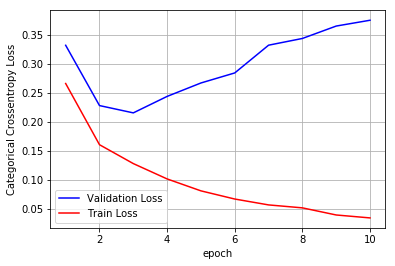

In [18]:
print()
print()

# Plot train and cross validation error
plot_train_cv_loss(trained_model, epochs)

# 2 LSTM Layer

In [19]:
%%time
# Instantiate sequntial model
model = Sequential()

# Add Embedding Layer
model.add(Embedding(vocab_size, embedding_vecor_length, input_length=max_review_length))

# Add batch normalization
model.add(BatchNormalization())

# Add dropout
model.add(Dropout(0.20))

# Add LSTM Layer 1
model.add(LSTM(100,return_sequences=True))

# Add dropout
model.add(Dropout(0.20))

# Add LSTM Layer 2
model.add(LSTM(100))

# Add dropout
model.add(Dropout(0.20))

# Add Dense Layer
model.add(Dense(1, activation='sigmoid'))

# Summary of the model
print("Model Summary: \n")
model.summary()
print()
print()

# Compile the model 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Run the model
trained_model = model.fit(x_train, np.array(y_train), batch_size = batch_size, epochs = epochs, verbose=1, validation_data=(x_test, y_test))

Model Summary: 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 32)           864096    
_________________________________________________________________
batch_normalization_2 (Batch (None, 500, 32)           128       
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 500, 100)          53200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 500, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0   

Test accuracy: 91.26%




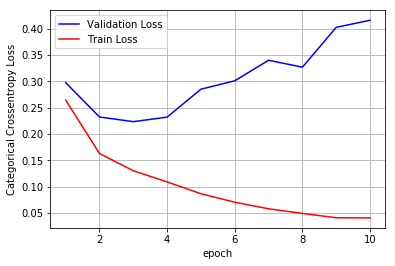

In [20]:
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test accuracy: {0:.2f}%'.format(score[1]*100))
print()
print()

# Plot train and cross validation error
plot_train_cv_loss(trained_model, epochs)

# 3 LSTM Layer

In [21]:
model = Sequential()

# Add Embedding Layer
model.add(Embedding(vocab_size, embedding_vecor_length, input_length=max_review_length))

# Add batch normalization
model.add(BatchNormalization())

# Add dropout
model.add(Dropout(0.20))

# Add LSTM Layer 1
model.add(LSTM(100,return_sequences=True,bias_regularizer=reg))

# Add dropout
model.add(Dropout(0.20))

# Add LSTM Layer 2
model.add(LSTM(80,return_sequences=True,bias_regularizer=reg))

# Add dropout
model.add(Dropout(0.20))

# Add LSTM Layer 3
model.add(LSTM(60,return_sequences=True,bias_regularizer=reg))

# Add dropout
model.add(Dropout(0.30))

# Add LSTM Layer 4
model.add(LSTM(40,return_sequences=True,bias_regularizer=reg))

# Add batch normalization
model.add(BatchNormalization())

# Add dropout
model.add(Dropout(0.40))

# Add LSTM Layer 5
model.add(LSTM(20))

# Add dropout
model.add(Dropout(0.50))

# Add Dense Layer
model.add(Dense(1, activation='sigmoid'))

# Summary of the model
print("Model Summary: \n")
model.summary()
print()
print()

# Compile the model 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Run the model
trained_model = model.fit(x_train, np.array(y_train), batch_size = batch_size, epochs = epochs, verbose=1, validation_data=(x_test, y_test))

Model Summary: 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 32)           864096    
_________________________________________________________________
batch_normalization_3 (Batch (None, 500, 32)           128       
_________________________________________________________________
dropout_6 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 500, 100)          53200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 500, 100)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 500, 80)           57920     
_________________________________________________________________
dropout_8 (Dropout)          (None, 500, 80)           0   

In [22]:
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test accuracy: {0:.2f}%'.format(score[1]*100))

Test accuracy: 91.33%


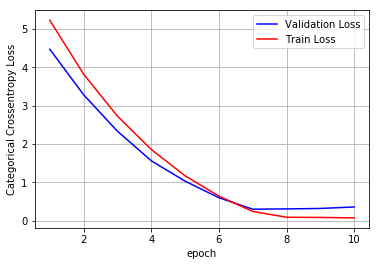

In [23]:
print()
print()

# Plot train and cross validation error
plot_train_cv_loss(trained_model, epochs)